In [37]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set the font family to serif and specify 'Computer Modern', which is the default LaTeX font
mpl.rc('font', family='serif', serif='Computer Modern')

# Adjust font sizes to match your LaTeX document
mpl.rcParams.update({
    'font.size': 12,        # Base font size
    'axes.titlesize': 12,   # Title font size
    'axes.labelsize': 12,   # Axes labels font size
    'xtick.labelsize': 10,   # X-axis tick labels font size
    'ytick.labelsize': 10,   # Y-axis tick labels font size
    'legend.fontsize': 10,   # Legend font size
    'figure.titlesize': 14  # Figure title font size
})

# Optional: Adjust line widths and marker sizes if needed
mpl.rcParams['lines.linewidth'] = 1.0
mpl.rcParams['lines.markersize'] = 4


In [38]:
# Cell 1: Imports
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import linregress
%matplotlib inline


In [39]:
# Cell 2: Constants
G = 6.67430e-11     # Gravitational constant (m^3 kg^-1 s^-2)
c = 2.998e8         # Speed of light (m/s)
kB = 1.380649e-23   # Boltzmann constant (J/K)
M_sol = 2e30        # Solar mass (kg)
sigma = 5.67e-8     # Stefan-Boltzmann constant (W/m^2/K^4)
h = 6.626e-34       # Planck constant (J·s)


In [40]:
# Cell 3: Parameters (User-Adjustable)

# Black Hole and Accretion Parameters
M_BH = M_sol * 1e8  # Black hole mass (kg)
dot_M = 1.225e-7 * M_sol        # Accretion rate (kg/s) Calculated the correct accretion rate , initially half 

# Grid Setup
num_points = 1000               # Number of radial grid points
num_angular_sections = 180      # Number of angular grid points

# Radial Range Factors
R_in_factor = 6     # Inner radius factor (e.g., 6 for ISCO)
R_out_factor = 100  # Outer radius factor in terms of ISCO

# Time Setup
warm_up_time = 200          # Warm-up time (seconds)
total_simulation_time = 10000  # Total simulation time (seconds)
time_points = 1000       # Number of time points

# Flare Parameters
num_flares = 1000  # Number of flares

# Flare Temperature Increase Factors
flare_temp_increase_min = 1.1    # Minimum temperature increase factor
flare_temp_increase_max = 1.5  # Maximum temperature increase factor
flare_temp_increase_power_law_index = 1.5  # Power-law index

# Flare Durations
flare_rise_time_min = 10    # Minimum flare rise time (seconds)
flare_rise_time_max = 50    # Maximum flare rise time (seconds)
flare_e_folding_time_min =20 # Minimum e-folding time (seconds)
flare_e_folding_time_max = 100  # Maximum e-folding time (seconds)
flare_decay_e_folding_multiplicator = 5  # Number of e-folding times in decay phase

# Flare Sizes (Radial and Angular)
min_flare_size_r = 1e9      # Minimum flare radial size (meters)
max_flare_size_r = 1e11     # Maximum flare radial size (meters)
min_flare_size_theta = np.pi / 100  # Minimum flare angular size (radians)
max_flare_size_theta = np.pi / 10   # Maximum flare angular size (radians)
flare_size_r_grid_multiplier = 10  # Minimum radial grid cells for flare size
flare_size_theta_grid_multiplier = 10  # Minimum angular grid cells for flare size


In [41]:
# Cell 4: Calculate ISCO Radius
def calculate_R_ISCO(M_BH):
    """
    Calculate ISCO radius for a non-rotating Black hole (meters)
    """
    return 6 * G * M_BH / c**2

R_ISCO = calculate_R_ISCO(M_BH)


In [42]:
# Cell 5: Radial and Angular Setup
R_in = R_in_factor * G * M_BH / c**2   # Inner radius (meters)
R_out = R_out_factor * R_ISCO          # Outer radius (meters)
R_disc= R_out 
print(np.log(R_ISCO))
print(R_disc/max_flare_size_r)
radii = np.linspace(R_in, R_out, num_points)   # Radial positions (meters)
dr = radii[1] - radii[0]                        # Radial grid spacing (meters)
dtheta = 2 * np.pi / num_angular_sections        # Angular grid spacing (radians)
theta_coords = np.linspace(0, 2 * np.pi, num_angular_sections, endpoint=False)  # Angular positions (radians)


27.515716203235016
891.094396486695


In [43]:
# Cell 6: Temperature Profile Function
def T_GR(R):
    """
    Computes the temperature profile T_GR(R) based on gravitational radius scaling.
    Ensures temperature is above a minimum threshold.
    """
    T_N4 = (3 * G * M_BH * dot_M) / (8 * np.pi * R**3 * sigma)
    T_eff = 1.1 * ((1 - (3 * G * M_BH) / (2 * R * c**2))**0.5) * np.maximum(T_N4, 1e-3)**0.25
    return T_eff


In [44]:
# Cell 7: Base Temperature Profile
temperature = T_GR(radii)
temperature = np.maximum(temperature, 273)  # Set minimum temperature to 273 K


In [45]:
# Cell 8: Time Grid
times = np.linspace(-warm_up_time, total_simulation_time, time_points)  # Time array (seconds)


In [46]:
# Cell 9: Initialize Fluctuating Temperature Array
fluctuating_temperature = np.zeros((num_points, num_angular_sections, len(times)), dtype=np.float32) 


In [47]:
# Cell 10: Flare Parameters Setup

# Flare Temperature Increases
temperature_increases = flare_temp_increase_min + (flare_temp_increase_max - flare_temp_increase_min) * np.random.power(a=flare_temp_increase_power_law_index, size=num_flares) 

# Randomly Assign Flare Times, Radii, and Angles
flare_times = np.random.choice(times, size=num_flares, replace=False)
flare_radii = np.random.choice(radii, size=num_flares, replace=True)
flare_angles = np.random.randint(0, num_angular_sections, size=num_flares)


In [48]:
# Cell 11: Flare Durations

# Flare Rise Times (seconds)
flare_rise_times = np.random.randint(flare_rise_time_min, flare_rise_time_max+1, size=num_flares)

# E-folding Times for Exponential Decay (seconds)
flare_e_folding_times = np.random.randint(flare_e_folding_time_min, flare_e_folding_time_max+1, size=num_flares)

# Decay Durations
flare_decay_times = flare_decay_e_folding_multiplicator * flare_e_folding_times

# Total Flare Durations
total_flare_durations = flare_rise_times + flare_decay_times


In [49]:
# Cell 12: Flare Sizes

# Flare Sizes in Physical Units
flare_size_r = np.random.uniform(min_flare_size_r, max_flare_size_r, size=num_flares)
flare_size_theta = np.random.uniform(min_flare_size_theta, max_flare_size_theta, size=num_flares)

# Ensure Flare Sizes are Larger Than Grid Spacing
flare_size_r = np.maximum(flare_size_r, flare_size_r_grid_multiplier * dr)
flare_size_theta = np.maximum(flare_size_theta, flare_size_theta_grid_multiplier * dtheta)


In [50]:
# Cell 13: Apply Flares to the Temperature Grid
for i in range(num_flares):
    flare_r = flare_radii[i]
    flare_theta = flare_angles[i] * dtheta
    flare_size_r_i = flare_size_r[i]
    flare_size_theta_i = flare_size_theta[i]
    
    # Time Indices
    t_start = np.argmin(np.abs(times - flare_times[i]))
    t_rise = flare_rise_times[i]
    t_decay = flare_decay_times[i]
    t_end = min(t_start + t_rise + t_decay, len(times))
    flare_time_indices = np.arange(t_start, t_end)
    
    # Time Since Flare Start
    time_since_start = times[flare_time_indices] - times[t_start]
    
    # Rising and Decay Phases
    rise_indices = time_since_start <= t_rise
    decay_indices = time_since_start > t_rise
    
    # Radial and Angular Indices
    r_indices = np.where(np.abs(radii - flare_r) <= flare_size_r_i / 2)[0]
    angular_diffs = np.abs(theta_coords - flare_theta)
    angular_diffs = np.minimum(angular_diffs, 2 * np.pi - angular_diffs)
    theta_indices = np.where(angular_diffs <= flare_size_theta_i / 2)[0]
    
    # Skip if No Cells are Affected
    if len(r_indices) == 0 or len(theta_indices) == 0:
        continue
    
    # Meshgrid of Affected Indices
    r_grid, theta_grid = np.meshgrid(r_indices, theta_indices, indexing='ij')
    
    # Temperature Increase Array
    delta_temperature_cells = np.zeros((len(r_indices), len(theta_indices), len(flare_time_indices)))
    
    # Rising Phase (Linear Rise)
    if np.any(rise_indices):
        rise_times = time_since_start[rise_indices]
        rise_fraction = rise_times / t_rise
        delta_temperature_rise = ((temperature_increases[i] - 1) * temperature[r_indices][:, np.newaxis, np.newaxis]) * rise_fraction[np.newaxis, np.newaxis, :]
        delta_temperature_cells[:, :, rise_indices] = delta_temperature_rise
    
    # Decay Phase (Exponential Decay)
    if np.any(decay_indices):
        decay_times = time_since_start[decay_indices] - t_rise
        tau = flare_e_folding_times[i]
        decay_fraction = np.exp(-decay_times / tau)
        delta_temperature_decay = ((temperature_increases[i] - 1) * temperature[r_indices][:, np.newaxis, np.newaxis]) * decay_fraction[np.newaxis, np.newaxis, :]
        delta_temperature_cells[:, :, decay_indices] = delta_temperature_decay
    
    # Update Fluctuating Temperature
    fluctuating_temperature[r_grid[:, :, np.newaxis], theta_grid[:, :, np.newaxis], flare_time_indices] += delta_temperature_cells


In [51]:
# Cell 14: Planck's Law Function
def planck_law(wavelength, temperature):
    """
    Computes the spectral radiance using Planck's Law.
    Args:
        wavelength (float or np.ndarray): Wavelength(s) in meters.
        temperature (np.ndarray): Temperature(s) in Kelvin.
    Returns:
        np.ndarray: Spectral radiance (W·m^-2·m^-1).
    """
    temperature = np.maximum(temperature, 1)  # Avoid division by zero
    exponent = (h * c) / (wavelength * kB * temperature)
    clipped_exponent = np.clip(exponent, -700, 700)  # Prevent overflow
    
    spectral_exitance = (2 * np.pi * h * c**2) / (wavelength**5 * (np.exp(clipped_exponent) - 1))
    spectral_exitance = np.nan_to_num(spectral_exitance, nan=0.0, posinf=0.0, neginf=0.0)
    
    return spectral_exitance


In [52]:
# Cell 15: Total Temperature
total_temperature = temperature[:, np.newaxis, np.newaxis] + fluctuating_temperature


In [53]:
# Cell 16: Wavelengths for Spectral Radiance Calculation
wavelengths = np.array([100e-9, 200e-9, 300e-9, 400e-9, 500e-9])  # 100 nm to 500 nm


In [54]:
# Cell 17: Compute Cell Areas
areas = (radii * dr * dtheta)[:, np.newaxis, np.newaxis]


In [55]:
# Cell 18: Initialize Luminosity Array
luminosity = np.zeros((len(wavelengths), len(times)), dtype=np.float64)


In [56]:
# Cell 19: Calculate Spectral Radiance and Luminosity
for idx, wavelength in enumerate(wavelengths):
    print(f"Processing wavelength: {int(wavelength*1e9)} nm")
    spectral_radiance = planck_law(wavelength, total_temperature)
    luminosity[idx, :] = np.sum(spectral_radiance * areas, axis=(0, 1))


Processing wavelength: 100 nm
Processing wavelength: 200 nm
Processing wavelength: 300 nm
Processing wavelength: 400 nm
Processing wavelength: 500 nm


In [57]:
# Cell 20: Compute Magnitudes Function
def compute_magnitudes(luminosity, times):
    """
    Computes magnitudes based on luminosity data.
    Args:
        luminosity (np.ndarray): Luminosity array (num_wavelengths, time_points).
        times (np.ndarray): Time array (seconds).
    Returns:
        np.ndarray: Magnitudes array (num_wavelengths, time_points).
    """
    sf_mask = times >= 0  
    filtered_times = times[sf_mask]
    filtered_luminosity = luminosity[:, sf_mask]
    
    L_mean = np.mean(filtered_luminosity, axis=1, keepdims=True)
    L_mean = np.maximum(L_mean, 1e-20)
    
    magnitudes = -2.5 * np.log10(filtered_luminosity / L_mean)
    
    return filtered_times, magnitudes


In [58]:
# Cell 21: Compute Magnitudes
filtered_times, magnitudes = compute_magnitudes(luminosity, times)


In [59]:
# Cell 22: Compute Color Indices Function
def compute_color_indices(magnitudes, wavelengths):
    """
    Computes color indices based on magnitude differences between consecutive wavelengths.
    Args:
        magnitudes (np.ndarray): Magnitudes array (num_wavelengths, time_points).
        wavelengths (np.ndarray): Wavelengths array (meters).
    Returns:
        dict: Dictionary of color indices with keys as wavelength pairs.
    """
    colors = {}
    for i in range(len(wavelengths) - 1):
        mag1 = magnitudes[i, :]
        mag2 = magnitudes[i + 1, :]
        color_index = mag1 - mag2
        colors[f"{int(wavelengths[i]*1e9)}-{int(wavelengths[i+1]*1e9)} nm"] = color_index
    return colors


In [60]:
# Cell 23: Compute Color Indices
colors = compute_color_indices(magnitudes, wavelengths)


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

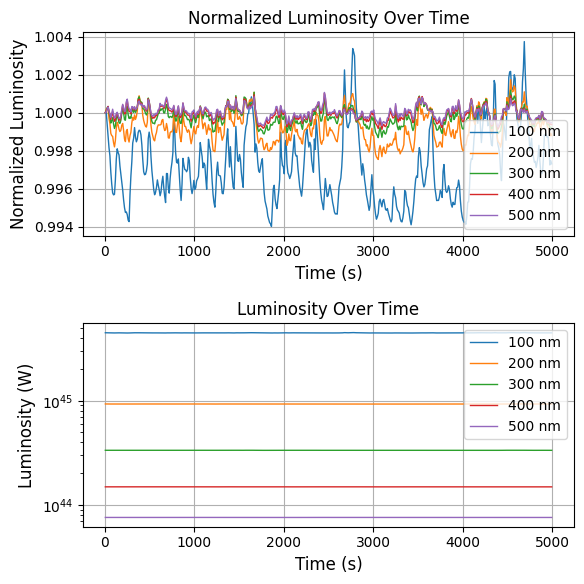

In [61]:
# Cell 24: Plot Normalized Luminosity Over Time and Luminosity Over Time

start_time = 1   # Start time in seconds
end_time = 5000  # End time in seconds

# Create figure and subplots
plt.figure(figsize=(6, 6))  # Adjust figure size for double-column format (in inches)

# First subplot: Normalized Luminosity Over Time
plt.subplot(2, 1, 1)

for i, wavelength in enumerate(wavelengths):
    # Extract luminosity after warm-up period
    luminosity_i = luminosity[i, times >= 0]

    # Corresponding filtered times after warm-up
    times_i = times[times >= 0]

    # Create a mask for the desired time range
    mask = (times_i >= start_time) & (times_i <= end_time)

    # Apply the mask to luminosity and times
    luminosity_subset = luminosity_i[mask]
    times_subset = times_i[mask]

    # Check if there are any data points in the specified range
    if len(luminosity_subset) == 0:
        print(f"No data available for wavelength {int(wavelength*1e9)} nm in the specified time range.")
        continue

    # Normalize luminosity so that the initial value in the subset is 1
    luminosity_normalized = luminosity_subset / luminosity_subset[0]

    # Plot the normalized luminosity
    plt.plot(times_subset, luminosity_normalized, label=f'{int(wavelength*1e9)} nm')

plt.xlabel('Time (s)')
plt.ylabel('Normalized Luminosity')
plt.title('Normalized Luminosity Over Time')
plt.legend()
plt.grid(True)

# Second subplot: Luminosity Over Time
plt.subplot(2, 1, 2)

for i, wavelength in enumerate(wavelengths):
    # Extract luminosity after warm-up period
    luminosity_i = luminosity[i, times >= 0]

    # Corresponding filtered times after warm-up
    times_i = times[times >= 0]

    # Create a mask for the desired time range
    mask = (times_i >= start_time) & (times_i <= end_time)

    # Apply the mask to luminosity and times
    luminosity_subset = luminosity_i[mask]
    times_subset = times_i[mask]

    # Check if there are any data points in the specified range
    if len(luminosity_subset) == 0:
        continue

    # Plot the luminosity
    plt.plot(times_subset, luminosity_subset, label=f'{int(wavelength*1e9)} nm')

plt.xlabel('Time (s)')
plt.yscale('log')
plt.ylabel('Luminosity (W)')  # Include units
plt.title('Luminosity Over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()

# Save the plot
plt.savefig('luminosity_plots.pdf', format='pdf')

plt.show()


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

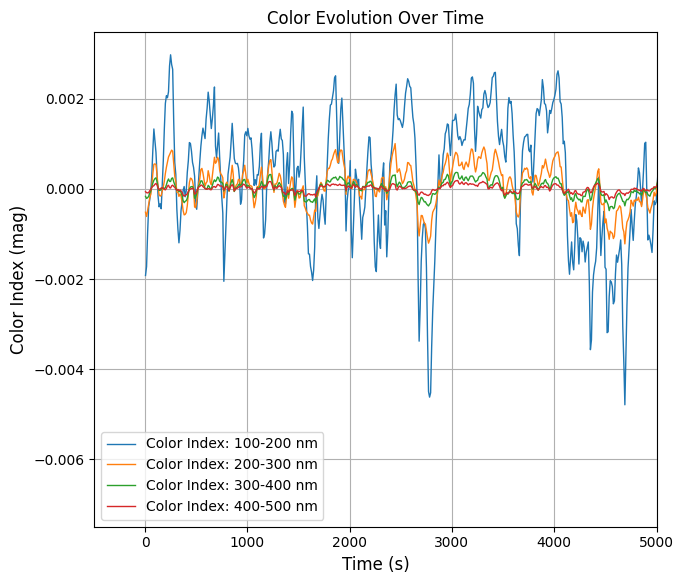

In [62]:
# Cell 25: Plot Color Indices Over Time
plt.figure(figsize=(7, 6))
for color_label, color_data in colors.items():
    plt.plot(filtered_times, color_data, label=f'Color Index: {color_label}')
plt.xlabel('Time (s)')
#plt.xscale('log')
plt.xlim(None,5000 )  # Set x-axis to end till 5000 seconds
plt.ylabel('Color Index (mag)')
plt.title('Color Evolution Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('color evolution_2.pdf', format='pdf')
plt.show()


In [63]:
# Cell X: Calculate Color Indices Over Time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure that 'magnitudes' and 'times' are defined and have consistent dimensions
# 'magnitudes' should be a 2D array of shape (num_wavelengths, num_time_points)
# 'times' should be a 1D array of time points

# Verify that 'magnitudes' and 'times' have matching dimensions
num_time_points_magnitudes = magnitudes.shape[1]
num_time_points_times = len(times)

if num_time_points_magnitudes != num_time_points_times:
    print("Mismatch detected between 'times' and 'magnitudes' time dimensions.")
    print("Aligning arrays by truncating to the minimum length...")
    min_length = min(num_time_points_magnitudes, num_time_points_times)
    magnitudes = magnitudes[:, :min_length]
    times = times[:min_length]
    print(f"Truncated both 'magnitudes' and 'times' to {min_length} time points.")
else:
    print("No mismatch detected between 'times' and 'magnitudes' time dimensions.")

# Define pairs of wavelengths for which to calculate color indices
# For example, we'll calculate color indices between adjacent wavelengths
wavelength_pairs = []
for i in range(len(wavelengths) - 1):
    wavelength_pairs.append((wavelengths[i], wavelengths[i+1]))

# Initialize a dictionary to store color indices
color_indices = {}

# Calculate color indices over time for each pair
for (lambda1, lambda2) in wavelength_pairs:
    # Find indices of the wavelengths in the 'wavelengths' array
    idx1 = np.where(wavelengths == lambda1)[0][0]
    idx2 = np.where(wavelengths == lambda2)[0][0]
    
    # Extract magnitudes for the two wavelengths
    mag1 = magnitudes[idx1, :]
    mag2 = magnitudes[idx2, :]
    
    # Calculate the color index
    color_index = mag1 - mag2  # Color index: m1 - m2
    
    # Store the color index with a key indicating the wavelength pair
    pair_label = f"{int(lambda1*1e9)}-{int(lambda2*1e9)} nm"
    color_indices[pair_label] = color_index

color_index_stats = []

for pair_label, color_index in color_indices.items():
    mean_ci = np.mean(color_index)
    std_ci = np.std(color_index)
    
    # Store the statistics
    color_index_stats.append({
        'Color Index (nm)': pair_label,
        'Mean (mag)': mean_ci,
        'Standard Deviation (mag)': std_ci
    })

# Create a DataFrame for better visualization
color_index_stats_df = pd.DataFrame(color_index_stats)

# Display the DataFrame
print("Color Index Statistics:")
display(color_index_stats_df)

# Convert the DataFrame to LaTeX table
latex_table = color_index_stats_df.to_latex(index=False, float_format="%.4f")
print("LaTeX Table:")
print(latex_table)

Mismatch detected between 'times' and 'magnitudes' time dimensions.
Aligning arrays by truncating to the minimum length...
Truncated both 'magnitudes' and 'times' to 980 time points.
Color Index Statistics:


,Color Index (nm),Mean (mag),Standard Deviation (mag)
0,100-200 nm,1.966417e-06,0.001638
1,200-300 nm,2.105980e-07,0.000462
2,300-400 nm,4.630696e-08,0.000169
3,400-500 nm,1.857669e-08,0.000078


LaTeX Table:
\begin{tabular}{lrr}
\toprule
Color Index (nm) & Mean (mag) & Standard Deviation (mag) \\
\midrule
100-200 nm & 0.0000 & 0.0016 \\
200-300 nm & 0.0000 & 0.0005 \\
300-400 nm & 0.0000 & 0.0002 \\
400-500 nm & 0.0000 & 0.0001 \\
\bottomrule
\end{tabular}



In [64]:
#cell 25.1 
# Plot a sample magnitude time series to verify alignment
#plt.figure(figsize=(10, 4))
#sample_wavelength = wavelengths[3]  # Change index as needed
#plt.plot(times, magnitudes[0, :], label=f'Sample Wavelength {int(sample_wavelength*1e9)} nm')
#plt.xlabel('Time (s)')
#plt.ylabel('Magnitude')
#plt.title('Sample Magnitude Time Series After Truncation')
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()


In [65]:
# Cell 26: Compute Normalized and Non-Normalized Structure Functions for Magnitudes and Calculate Slopes

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import pandas as pd

def compute_structure_functions(magnitude_data, times, num_bins=20, time_lag_ranges=None):
    """
    Computes both normalized and non-normalized structure functions for given magnitude data
    and calculates slopes globally and within specified time lag ranges.
    
    Args:
        magnitude_data (np.ndarray): Magnitude data (time_points,).
        times (np.ndarray): Time array corresponding to magnitude_data (seconds).
        num_bins (int): Number of bins for time lags.
        time_lag_ranges (list of tuples): List of (min_lag, max_lag) tuples for slope calculations.
    
    Returns:
        tuple: (lag_bin_centers, sf_non_normalized, sf_normalized, slopes)
               where slopes is a dictionary containing:
                   'global_normalized': slope for normalized SF
                   'global_non_normalized': slope for non-normalized SF
                   'range_normalized': dict of slopes for normalized SF within specified ranges
                   'range_non_normalized': dict of slopes for non-normalized SF within specified ranges
    """
    # Ensure there are enough data points
    if len(times) < 2:
        raise ValueError("Insufficient data points to compute the structure function.")
    
    # Compute time differences and magnitude differences
    time_diffs = np.subtract.outer(times, times)  # Shape: (N, N)
    mag_diffs = np.subtract.outer(magnitude_data, magnitude_data)  # Shape: (N, N)
    
    # Use only positive time lags
    mask = time_diffs > 0
    time_lags = time_diffs[mask]
    mag_diffs_squared = mag_diffs[mask] ** 2
    
    # Check if there are any positive time lags
    if len(time_lags) == 0:
        raise ValueError("No positive time lags found in the data.")
    
    # Define lag bins (logarithmic spacing)
    lag_bins = np.logspace(np.log10(np.min(time_lags)), np.log10(np.max(time_lags)), num_bins)
    
    # Initialize structure function arrays
    sf_non_normalized = np.zeros(len(lag_bins) - 1)
    sf_normalized = np.zeros(len(lag_bins) - 1)
    
    # Compute non-normalized structure function
    for i in range(len(lag_bins) - 1):
        bin_mask = (time_lags >= lag_bins[i]) & (time_lags < lag_bins[i + 1])
        if np.sum(bin_mask) > 0:
            sf_non_normalized[i] = np.mean(mag_diffs_squared[bin_mask])
        else:
            sf_non_normalized[i] = np.nan  # Assign NaN if no data points in the bin
    
    # Normalize the structure function by the variance of the magnitude data
    variance_mag = np.var(magnitude_data)
    if variance_mag == 0:
        raise ValueError("Variance of magnitude data is zero; cannot normalize structure function.")
    
    sf_normalized = sf_non_normalized / variance_mag
    
    # Compute lag bin centers for plotting
    lag_bin_centers = np.sqrt(lag_bins[:-1] * lag_bins[1:])
    
    # Initialize dictionary to store slopes
    slopes = {
        'global_normalized': np.nan,
        'global_non_normalized': np.nan,
        'range_normalized': {},
        'range_non_normalized': {}
    }
    
    # Fit a linear regression on log-log space to find the global slope for normalized SF
    # Exclude bins with NaN or non-positive SF values
    valid_norm = ~np.isnan(sf_normalized) & (sf_normalized > 0)
    if np.sum(valid_norm) >= 2:
        log_lag_norm = np.log10(lag_bin_centers[valid_norm])
        log_sf_norm = np.log10(sf_normalized[valid_norm])
        slope_norm, intercept, r_value, p_value, std_err = linregress(log_lag_norm, log_sf_norm)
        slopes['global_normalized'] = slope_norm
    else:
        slopes['global_normalized'] = np.nan
    
    # Fit a linear regression on log-log space to find the global slope for non-normalized SF
    valid_non_norm = ~np.isnan(sf_non_normalized) & (sf_non_normalized > 0)
    if np.sum(valid_non_norm) >= 2:
        log_lag_non_norm = np.log10(lag_bin_centers[valid_non_norm])
        log_sf_non_norm = np.log10(sf_non_normalized[valid_non_norm])
        slope_non_norm, intercept, r_value, p_value, std_err = linregress(log_lag_non_norm, log_sf_non_norm)
        slopes['global_non_normalized'] = slope_non_norm
    else:
        slopes['global_non_normalized'] = np.nan
    
    # If specific time lag ranges are provided, compute slopes within those ranges
    if time_lag_ranges is not None:
        for (min_lag, max_lag) in time_lag_ranges:
            # Normalized SF slope within the range
            range_mask_norm = (lag_bin_centers >= min_lag) & (lag_bin_centers <= max_lag) & (sf_normalized > 0)
            if np.sum(range_mask_norm) >= 2:
                log_lag_range_norm = np.log10(lag_bin_centers[range_mask_norm])
                log_sf_range_norm = np.log10(sf_normalized[range_mask_norm])
                slope_range_norm, intercept, r_value, p_value, std_err = linregress(log_lag_range_norm, log_sf_range_norm)
                slopes['range_normalized'][f"{min_lag}-{max_lag}"] = slope_range_norm
            else:
                slopes['range_normalized'][f"{min_lag}-{max_lag}"] = np.nan
            
            # Non-normalized SF slope within the range
            range_mask_non_norm = (lag_bin_centers >= min_lag) & (lag_bin_centers <= max_lag) & (sf_non_normalized > 0)
            if np.sum(range_mask_non_norm) >= 2:
                log_lag_range_non_norm = np.log10(lag_bin_centers[range_mask_non_norm])
                log_sf_range_non_norm = np.log10(sf_non_normalized[range_mask_non_norm])
                slope_range_non_norm, intercept, r_value, p_value, std_err = linregress(log_lag_range_non_norm, log_sf_range_non_norm)
                slopes['range_non_normalized'][f"{min_lag}-{max_lag}"] = slope_range_non_norm
            else:
                slopes['range_non_normalized'][f"{min_lag}-{max_lag}"] = np.nan
    
    return lag_bin_centers, sf_non_normalized, sf_normalized, slopes

# Initialize dictionaries to store slopes and structure functions for each wavelength
sf_slopes = {}
sf_slopes_ranges = {}
sf_data_non_normalized = {}
sf_data_normalized = {}

# Define the time lag ranges for slope calculations (in seconds)
time_lag_ranges = [
    (1000,1800),
    # Add more ranges as needed
]

# Assuming 'magnitudes' is a 2D array with shape (num_wavelengths, num_time_points)
# and 'times' is a 1D array with shape (num_time_points,)

# Verify that magnitudes and times have consistent dimensions
num_time_points_magnitudes = magnitudes.shape[1]
num_time_points_times = len(times)

print(f"Number of time points in 'magnitudes': {num_time_points_magnitudes}")
print(f"Number of time points in 'times': {num_time_points_times}")

if num_time_points_magnitudes != num_time_points_times:
    print("Mismatch detected between 'times' and 'magnitudes' time dimensions.")
    print("Identifying overlapping time range...")
    
    # Determine the minimum length
    min_length = min(num_time_points_magnitudes, num_time_points_times)
    
    # Truncate both arrays to the minimum length
    magnitudes = magnitudes[:, :min_length]
    times = times[:min_length]
    
    print(f"Truncated both 'magnitudes' and 'times' to {min_length} time points.")
else:
    print("No mismatch detected between 'times' and 'magnitudes' time dimensions.")

# Compute the structure functions and slopes for each wavelength
for idx, wavelength in enumerate(wavelengths):
    # Extract magnitude and time data for the current wavelength
    magnitude_i = magnitudes[idx, :]  # Shape: (num_time_points,)
    times_i = times  # Shape: (num_time_points,)
    
    # Compute the structure functions and slopes
    lag_centers, sf_non_norm, sf_norm, slopes = compute_structure_functions(
        magnitude_i, times_i, num_bins=50, time_lag_ranges=time_lag_ranges
    )
    
    # Store the global slopes
    sf_slopes[wavelength] = {
        'normalized_global': slopes['global_normalized'],
        'non_normalized_global': slopes['global_non_normalized']
    }
    
    # Store the slopes within specified ranges
    sf_slopes_ranges[wavelength] = {
        'normalized_ranges': slopes['range_normalized'],
        'non_normalized_ranges': slopes['range_non_normalized']
    }
    
    # Store the structure function data for plotting
    sf_data_non_normalized[wavelength] = (lag_centers, sf_non_norm)
    sf_data_normalized[wavelength] = (lag_centers, sf_norm)

# Display the global slopes
print("\nGlobal Structure Function Slopes (log-log space):")
for wavelength, slope_dict in sf_slopes.items():
    slope_norm = slope_dict['normalized_global']
    slope_non_norm = slope_dict['non_normalized_global']
    slope_norm_display = f"{slope_norm:.2f}" if not np.isnan(slope_norm) else "N/A"
    slope_non_norm_display = f"{slope_non_norm:.2f}" if not np.isnan(slope_non_norm) else "N/A"
    print(f"Wavelength {wavelength*1e9:.0f} nm: Slope (Normalized) = {slope_norm_display}, Slope (Non-Normalized) = {slope_non_norm_display}")


Number of time points in 'magnitudes': 980
Number of time points in 'times': 980
No mismatch detected between 'times' and 'magnitudes' time dimensions.

Global Structure Function Slopes (log-log space):
Wavelength 100 nm: Slope (Normalized) = 0.23, Slope (Non-Normalized) = 0.23
Wavelength 200 nm: Slope (Normalized) = 0.16, Slope (Non-Normalized) = 0.16
Wavelength 300 nm: Slope (Normalized) = 0.14, Slope (Non-Normalized) = 0.14
Wavelength 400 nm: Slope (Normalized) = 0.15, Slope (Non-Normalized) = 0.15
Wavelength 500 nm: Slope (Normalized) = 0.16, Slope (Non-Normalized) = 0.16


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

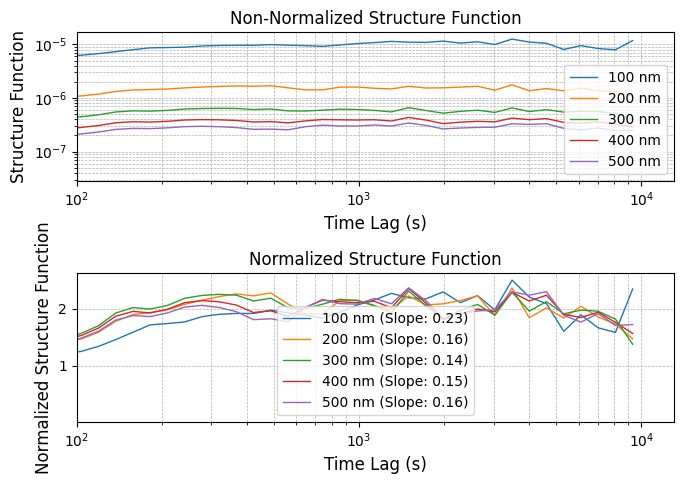

In [66]:
# Cell 27: Plot Normalized and Non-Normalized Structure Functions for All Wavelengths with Slope Annotations
# Cell 27: Plot Normalized and Non-Normalized Structure Functions for All Wavelengths with Slope Annotations

plt.figure(figsize=(7,5))  # Adjust figure size for full-width format (in inches)

# Plot Non-Normalized Structure Functions
plt.subplot(2, 1, 1)
for wavelength, (lag_centers, sf_non_norm) in sf_data_non_normalized.items():
    plt.plot(lag_centers, sf_non_norm, label=f'{int(wavelength*1e9)} nm')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Time Lag (s)')
plt.ylabel('Structure Function')
plt.title('Non-Normalized Structure Function')
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.xlim(1e2, None)  # Set x-axis to start from 100 seconds

# Plot Normalized Structure Functions with Slope Annotations
plt.subplot(2, 1, 2)
for wavelength, (lag_centers, sf_norm) in sf_data_normalized.items():
    slope = sf_slopes[wavelength]['normalized_global']
    slope_text = f"Slope: {slope:.2f}" if not np.isnan(slope) else "Slope: N/A"
    plt.plot(lag_centers, sf_norm, label=f'{int(wavelength*1e9)} nm ({slope_text})')
plt.xscale('log')
#plt.yscale('log')  # Uncomment if you prefer a logarithmic y-axis
plt.xlabel('Time Lag (s)')
plt.ylabel('Normalized Structure Function')
plt.title('Normalized Structure Function')
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.xlim(1e2, None)  # Set x-axis to start from 100 seconds

plt.tight_layout()

# Save the plot
plt.savefig('structure_functions.pdf', format='pdf')
plt.show()




In [67]:
# Cell 28: Generate a Summary Table of Structure Function Slopes

import pandas as pd

# Create a DataFrame for global slopes
global_slopes_df = pd.DataFrame({
    'Wavelength (nm)': [int(w*1e9) for w in sf_slopes.keys()],
    'Slope (Normalized SF - Global)': [s['normalized_global'] for s in sf_slopes.values()],
    'Slope (Non-Normalized SF - Global)': [s['non_normalized_global'] for s in sf_slopes.values()]
})

# Create DataFrame for range slopes
range_slopes_data = []
for wavelength in wavelengths:
    normalized_ranges = sf_slopes_ranges[wavelength]['normalized_ranges']
    non_normalized_ranges = sf_slopes_ranges[wavelength]['non_normalized_ranges']
    for (range_label, slope_norm) in normalized_ranges.items():
        slope_non_norm = non_normalized_ranges.get(range_label, np.nan)
        range_slopes_data.append({
            'Wavelength (nm)': int(wavelength*1e9),
            'Time Lag Range (s)': range_label,
            'Slope (Normalized SF)': slope_norm,
            'Slope (Non-Normalized SF)': slope_non_norm
        })

range_slopes_df = pd.DataFrame(range_slopes_data)

# Merge global and range slopes for comprehensive summary
summary_df = pd.merge(global_slopes_df, range_slopes_df, on='Wavelength (nm)', how='left')

# Sort the DataFrame by Wavelength
summary_df.sort_values(by='Wavelength (nm)', inplace=True)

# Reset index for neatness
summary_df.reset_index(drop=True, inplace=True)

# Display the summary table
print("Summary of Structure Function Slopes Across Wavelengths:")
display(summary_df)


Summary of Structure Function Slopes Across Wavelengths:


,Wavelength (nm),Slope (Normalized SF - Global),Slope (Non-Normalized SF - Global),Time Lag Range (s),Slope (Normalized SF),Slope (Non-Normalized SF)
0,100,0.230292,0.230292,1000-1800,-0.003387,-0.003387
1,200,0.164981,0.164981,1000-1800,0.104950,0.104950
2,300,0.143294,0.143294,1000-1800,0.116337,0.116337
3,400,0.152596,0.152596,1000-1800,0.078193,0.078193
4,500,0.163692,0.163692,1000-1800,0.051365,0.051365


Percentage RMS Variability of Flares at Different Wavelengths:


,Wavelength (nm),Mean Magnitude,Standard Deviation,Percentage RMS Variability (%)
0,100,-3.563949e-07,0.002252,-631743.270424
1,200,-3.775941e-07,0.000866,-229244.981730
2,300,-4.265402e-07,0.000537,-125827.124139
3,400,-3.437272e-07,0.000432,-125659.082710
4,500,-2.744308e-07,0.000382,-139123.806515


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

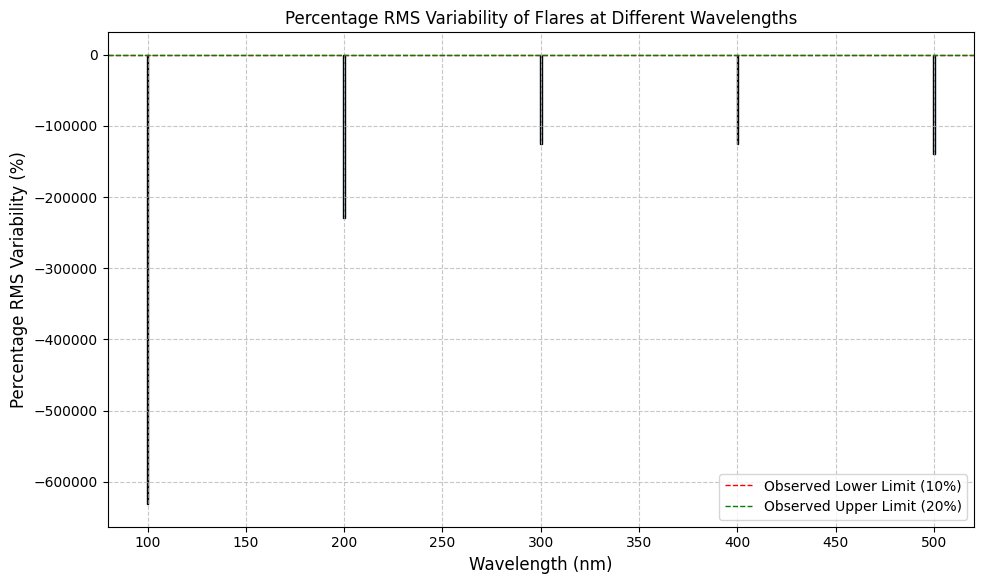

In [68]:
# Cell 29: Calculate Percentage RMS Variability of Flares

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define the time range over which to calculate the variability (in seconds)
# For example, consider the entire time after warm-up period (times >= 0)
time_range_mask = times >= 0
times_in_range = times[time_range_mask]

# Verify that times_in_range is not empty
if len(times_in_range) == 0:
    raise ValueError("No time points found within the specified time range.")

# Initialize a list to store RMS variability data for each wavelength
rms_variability_data = []

# Calculate the percentage RMS variability for each wavelength
for idx, wavelength in enumerate(wavelengths):
    # Extract magnitude data within the time range
    magnitudes_in_range = magnitudes[idx, time_range_mask]
    
    # Compute the mean and standard deviation of the magnitude data
    mean_mag = np.mean(magnitudes_in_range)
    std_mag = np.std(magnitudes_in_range)
    
    # Compute the percentage RMS variability
    percentage_rms_variability = (std_mag / mean_mag) * 100   # In percentage
    
    # Store the data
    rms_variability_data.append({
        'Wavelength (nm)': int(wavelength * 1e9),
        'Mean Magnitude': mean_mag,
        'Standard Deviation': std_mag,
        'Percentage RMS Variability (%)': percentage_rms_variability
    })

# Create a DataFrame for better visualization
rms_variability_df = pd.DataFrame(rms_variability_data)

# Display the DataFrame
print("Percentage RMS Variability of Flares at Different Wavelengths:")
display(rms_variability_df)



 # Plotting Percentage RMS Variability Across Wavelengths

plt.figure(figsize=(10, 6))
plt.bar(rms_variability_df['Wavelength (nm)'], rms_variability_df['Percentage RMS Variability (%)'],
        color='skyblue', edgecolor='black')
plt.axhline(10, color='red', linestyle='--', label='Observed Lower Limit (10%)')
plt.axhline(20, color='green', linestyle='--', label='Observed Upper Limit (20%)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Percentage RMS Variability (%)')
plt.title('Percentage RMS Variability of Flares at Different Wavelengths')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [69]:
# Verify that luminosity and times have consistent dimensions
num_time_points_luminosity = luminosity.shape[1]
num_time_points_times = len(times)

print(f"Number of time points in 'luminosity': {num_time_points_luminosity}")
print(f"Number of time points in 'times': {num_time_points_times}")

if num_time_points_luminosity != num_time_points_times:
    print("Mismatch detected between 'times' and 'luminosity' time dimensions.")
    print("Aligning arrays by truncating to the minimum length...")

    # Determine the minimum length
    min_length = min(num_time_points_luminosity, num_time_points_times)

    # Truncate both arrays to the minimum length
    luminosity = luminosity[:, :min_length]
    times = times[:min_length]

    print(f"Truncated both 'luminosity' and 'times' to {min_length} time points.")
else:
    print("No mismatch detected between 'times' and 'luminosity' time dimensions.")

# Now define your time_range_mask based on the updated 'times' array
# Define the time range over which to calculate the variability (e.g., times >= 0)
time_range_mask = times >= 0
times_in_range = times[time_range_mask]

# Verify that times_in_range is not empty
if len(times_in_range) == 0:
    raise ValueError("No time points found within the specified time range.")

# Proceed with the calculation
# Initialize a list to store RMS variability data for each wavelength
rms_variability_flux_data = []

# Calculate the percentage RMS variability using fluxes for each wavelength
for idx, wavelength in enumerate(wavelengths):
    # Extract flux data within the time range
    # Since we have ensured that 'luminosity' and 'times' have matching dimensions,
    # the 'time_range_mask' should now match the dimension of 'luminosity[idx, :]'
    flux_in_range = luminosity[idx, time_range_mask]

    # Check for negative or zero flux values
    if np.any(flux_in_range <= 0):
        print(f"Warning: Non-positive flux values found at wavelength {wavelength*1e9:.0f} nm.")
        # Optionally handle or exclude these values
        flux_in_range = flux_in_range[flux_in_range > 0]
        if len(flux_in_range) == 0:
            print(f"No positive flux values remain at wavelength {wavelength*1e9:.0f} nm after filtering. Skipping this wavelength.")
            continue

    # Compute the mean and standard deviation of the flux data
    mean_flux = np.mean(flux_in_range)
    std_flux = np.std(flux_in_range)

    # Ensure mean_flux is not zero to avoid division by zero
    if mean_flux == 0:
        print(f"Mean flux is zero at wavelength {wavelength*1e9:.0f} nm. Cannot compute percentage RMS variability. Skipping this wavelength.")
        continue

    # Compute the percentage RMS variability
    percentage_rms_variability_flux = (std_flux / mean_flux) * 100  # In percentage

    # Store the data
    rms_variability_flux_data.append({
        'Wavelength (nm)': int(wavelength * 1e9),
        'Mean Flux': mean_flux,
        'Standard Deviation': std_flux,
        'Percentage RMS Variability (%)': percentage_rms_variability_flux
    })

# Create a DataFrame for better visualization
rms_variability_flux_df = pd.DataFrame(rms_variability_flux_data)

# Display the DataFrame
print("Percentage RMS Variability of Flares at Different Wavelengths (Using Fluxes):")
display(rms_variability_flux_df)
# After calculating 'rms_variability_flux_df' as before

# Format the numerical columns
rms_variability_flux_df_formatted = rms_variability_flux_df.copy()
rms_variability_flux_df_formatted['Mean Flux'] = rms_variability_flux_df_formatted['Mean Flux'].apply(lambda x: f'{x:.2e}')
rms_variability_flux_df_formatted['Standard Deviation'] = rms_variability_flux_df_formatted['Standard Deviation'].apply(lambda x: f'{x:.2e}')
rms_variability_flux_df_formatted['Percentage RMS Variability (%)'] = rms_variability_flux_df_formatted['Percentage RMS Variability (%)'].apply(lambda x: f'{x:.2f}')

# Generate LaTeX table
latex_table = rms_variability_flux_df_formatted.to_latex(index=False, 
                                                         column_format='|c|c|c|c|', 
                                                         header=['Wavelength (nm)', 'Mean Flux (W)', 'Standard Deviation (W)', 'Percentage RMS Variability (\%)'],
                                                         escape=False)

# Print LaTeX table
print("LaTeX Table of Percentage RMS Variability of Flares at Different Wavelengths (Using Fluxes):\n")
print(latex_table)
 

Number of time points in 'luminosity': 1000
Number of time points in 'times': 980
Mismatch detected between 'times' and 'luminosity' time dimensions.
Aligning arrays by truncating to the minimum length...
Truncated both 'luminosity' and 'times' to 980 time points.
Percentage RMS Variability of Flares at Different Wavelengths (Using Fluxes):


<>:89: SyntaxWarning: invalid escape sequence '\%'
<>:89: SyntaxWarning: invalid escape sequence '\%'
/var/folders/qq/kgfcfd9969qgpgw0vdkdlg7r0000gn/T/ipykernel_7160/1528745460.py:89: SyntaxWarning: invalid escape sequence '\%'
  header=['Wavelength (nm)', 'Mean Flux (W)', 'Standard Deviation (W)', 'Percentage RMS Variability (\%)'],


,Wavelength (nm),Mean Flux,Standard Deviation,Percentage RMS Variability (%)
0,100,4.484823e+45,9.007736e+42,0.200849
1,200,9.298640e+44,7.336463e+41,0.078898
2,300,3.338462e+44,1.644419e+41,0.049257
3,400,1.487476e+44,5.887275e+40,0.039579
4,500,7.558948e+43,2.639220e+40,0.034915


LaTeX Table of Percentage RMS Variability of Flares at Different Wavelengths (Using Fluxes):

\begin{tabular}{|c|c|c|c|}
\toprule
Wavelength (nm) & Mean Flux (W) & Standard Deviation (W) & Percentage RMS Variability (\%) \\
\midrule
100 & 4.48e+45 & 9.01e+42 & 0.20 \\
200 & 9.30e+44 & 7.34e+41 & 0.08 \\
300 & 3.34e+44 & 1.64e+41 & 0.05 \\
400 & 1.49e+44 & 5.89e+40 & 0.04 \\
500 & 7.56e+43 & 2.64e+40 & 0.03 \\
\bottomrule
\end{tabular}



findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern


findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

11 170
41


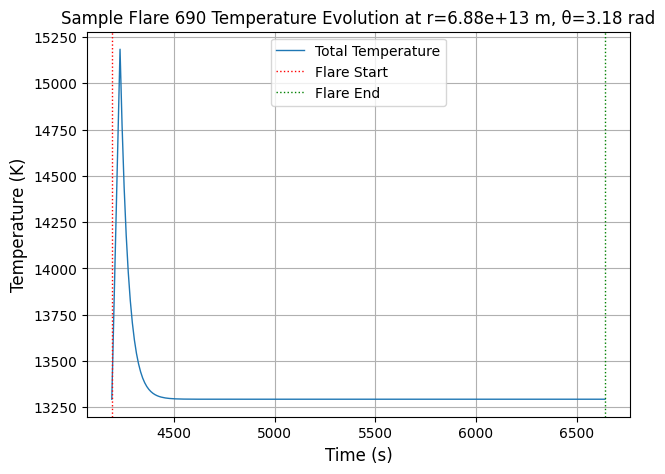

In [70]:
# Cell 28: Visualize Sample Flare Function (Optional)
def visualize_sample_flare(i=690):
    """
    Visualizes the temperature evolution of a sample flare.
    Args:
        i (int): Index of the flare to visualize.
    """
    if i >= num_flares:
        print(f"Flare index {i} is out of range.")
        return
    
    flare_r = flare_radii[i]
    flare_theta = flare_angles[i] * dtheta
    flare_size_r_i = flare_size_r[i]
    flare_size_theta_i = flare_size_theta[i]
    t_start = np.argmin(np.abs(times - flare_times[i]))
    t_rise = flare_rise_times[i]
    t_decay = flare_decay_times[i]
    t_end = min(t_start + t_rise + t_decay, len(times))
    flare_time_indices = np.arange(t_start, t_end)
    
    # Find Radial and Angular Indices
    r_indices = np.where(np.abs(radii - flare_r) <= flare_size_r_i / 2)[0]
    angular_diffs = np.abs(theta_coords - flare_theta)
    angular_diffs = np.minimum(angular_diffs, 2 * np.pi - angular_diffs)
    theta_indices = np.where(angular_diffs <= flare_size_theta_i / 2)[0]
    
    if len(r_indices) == 0 or len(theta_indices) == 0:
        print("No cells affected by this flare.")
        return
    
    # Sample Cell for Visualization
    sample_r = r_indices[0]
    sample_theta = theta_indices[0]
    
    # Extract Temperature Changes
    temp_change = fluctuating_temperature[sample_r, sample_theta, flare_time_indices]
    base_temp = temperature[sample_r]
    total_temp = base_temp + temp_change
    print(flare_rise_times[i])
    # Plot Temperature Over Time
    plt.figure(figsize=(7, 5))
    plt.plot(times[flare_time_indices], total_temp, label='Total Temperature')
    plt.axvline(x=times[t_start], color='r', linestyle=':', label='Flare Start')
    plt.axvline(x=times[t_end-1], color='g', linestyle=':', label='Flare End')
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (K)')
    plt.title(f'Sample Flare {i} Temperature Evolution at r={flare_r:.2e} m, θ={flare_theta:.2f} rad')
    plt.legend()
    plt.grid(True)
    plt.show()
print(flare_rise_times[i], flare_decay_times[i])
visualize_sample_flare()

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

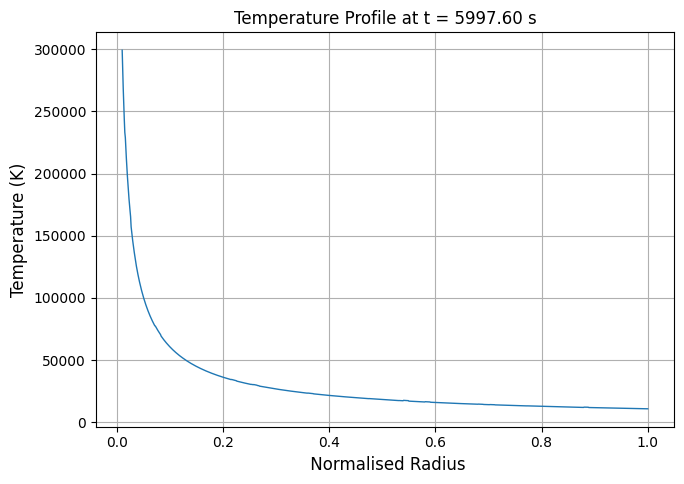

In [71]:
# Cell 30: Plot Temperature Profile at a Specific Time

def plot_temperature_profile_at_time(specific_time):
    """
    Plots the temperature profile of the accretion disk at a specific time.
    
    Args:
        specific_time (float): The time at which to plot the temperature profile (seconds).
    """
    # Ensure the specific time is within the simulation time range
    if specific_time < times[0] or specific_time > times[-1]:
        print(f"Time {specific_time} s is outside the simulation range ({times[0]} s to {times[-1]} s).")
        return
    
    # Find the index of the closest time to the specific_time
    time_index = np.argmin(np.abs(times - specific_time))
    actual_time = times[time_index]
    
    # Extract temperature data at the specific time
    temperature_at_time = total_temperature[:, :, time_index]  # Shape: (num_points, num_angular_sections)
    
    # Average over theta to get temperature as a function of radius
    temperature_profile = np.mean(temperature_at_time, axis=1)  # Shape: (num_points,)
    radii_norm = radii/np.max(radii)

    # Plot temperature profile
    plt.figure(figsize=(7, 5))
    plt.plot(radii_norm, temperature_profile)
    #plt.xscale('log')
    plt.xlabel(' Normalised Radius')
    plt.ylabel('Temperature (K)')
    plt.title(f'Temperature Profile at t = {actual_time:.2f} s')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
# You can specify any time within your simulation range
plot_temperature_profile_at_time(specific_time=6000)  # Replace  with desired time in seconds


# Changes in the code :
- For impulse flares , minimum random operator 
